In [105]:
import pandas as pd
import numpy as np
from os.path import join
import os
import json
from datetime import datetime, timezone
from twarc import Twarc2

# parallelisation functionality
from multiprocess import Pool
import psutil
from tqdm import tqdm

import sys
sys.path.insert(0, "/home/jana/Projects/utilities/twitter_functions")
import twitter_functions as tf

In [199]:
src = "../../data/twitter/"
dst = "../../data/twitter/US_politician_twitter_conversations"

cols =["id", "conversation_id", "author_id", "reply_count"]
tweets = pd.read_csv(join(src,
    "combined_US_politician_twitter_timelines_2010-11-06_to_2022-03-16_clean.csv.gzip"),
    compression="gzip", usecols=cols,
    dtype={"id":str, "conversation_id":str, "author_id":str})

# Get conversations

In [67]:
subset = tweets[(tweets["reply_count"] <= 500) & (tweets["reply_count"] > 0)]\
    .sort_values(by="reply_count", ascending=True)\
    .reset_index(drop=True)

# get only tweets that started a conversation
subset = subset[subset["id"] == subset["conversation_id"]]
# select every third conversation
subset = subset.iloc[::3]
subset["id"] = subset["id"].apply(lambda x: x.replace('"', ''))
np.savetxt(join(dst, "conversation_id_sample.txt"), subset["id"].values, fmt='%s')

In [69]:
N_replies = int(subset["reply_count"].sum())
N_tweets = len(subset)
print(f"{N_tweets} tweets with {N_replies} replies")

450432 tweets with 13089682 replies


In [92]:
cat conversation_id_sample.txt | xargs -i sh -c "twarc2 conversation --archive {} US_politician_twitter_conversations/{}.jsonl"

cat: '!': No such file or directory
cat: ls: No such file or directory
100%|███████████████| Processed 15 years/15 years [00:01<00:00, 1 tweets total ]
100%|███████████████| Processed 15 years/15 years [00:01<00:00, 1 tweets total ]
100%|███████████████| Processed 15 years/15 years [00:01<00:00, 1 tweets total ]
100%|███████████████| Processed 15 years/15 years [00:01<00:00, 1 tweets total ]
100%|███████████████| Processed 15 years/15 years [00:01<00:00, 1 tweets total ]


In [ ]:
! rsync -avze ssh jlasser@medea:/home/jlasser/Honesty-project/data/twitter/US_politician_twitter_conversations/ ../../data/twitter/US_politician_twitter_conversations/

# Collect conversations

In [ ]:
"entities.expanded_urls"  expansions.geo

In [244]:
def naneval(x):
    false = False
    true = True
    if x == x:
        return eval(x)
    else:
        return np.nan
    
def process_csv(df):
    df = df.rename(columns={
    "author.id":"author_id",
    "public_metrics.retweet_count":"retweet_count",
    "public_metrics.like_count":"like_count",
    "public_metrics.quote_count":"quote_count",
    "public_metrics.reply_count":"reply_count",
    "geo.place_id":"geo",
    })
    
    df["id"] = df["id"].apply(lambda x: f'"{x}"')
    df["author_id"] = df["author_id"].apply(lambda x: f'"{x}"')
    df["conversation_id"] = df["conversation_id"].apply(lambda x: f'"{x}"')
    
    df["referenced_tweets"] = df["referenced_tweets"].apply(naneval)
    df["entities.urls"] = df["entities.urls"].apply(naneval)
    reference_types = []
    urls = []
    expanded_urls = []
    for i, row in df.iterrows():
        tmp_reference_types = []
        tmp_urls = []
        tmp_expanded_urls = []
        if type(row['referenced_tweets']) == list:
            for rt in row['referenced_tweets']:
                if 'type' in rt.keys():
                    tmp_reference_types.append(rt["type"])
        if type(row['entities.urls']) == list:
            for url in row["entities.urls"]:
                if "url" in url.keys():
                    tmp_urls.append(url["url"])
                if "expanded_url" in url.keys():
                    tmp_expanded_urls.append(url["expanded_url"])
                    
        reference_types.append(tmp_reference_types)
        urls.append(tmp_urls)
        expanded_urls.append(tmp_expanded_urls)
        
    df["reference_type"] = reference_types
    df["urls"] = urls
    df["expanded_urls"] = expanded_urls  
                
    df["retweeted"] = df["reference_type"].apply(tf.check_retweet)
    df["quoted"] = df["reference_type"].apply(tf.check_quoted)
    df["reply"] = df["reference_type"].apply(tf.check_reply)
    df = df.drop(columns=["reference_type", "entities.urls",
                            "referenced_tweets"])
    
    return df

In [245]:
src = "../../data/twitter/US_politician_twitter_conversations_csv"
files = os.listdir(src)
cols = ["id", "author.id",
        "conversation_id", "created_at", "lang", "text",
        "public_metrics.retweet_count", "public_metrics.like_count",
        "public_metrics.quote_count","public_metrics.reply_count",
        "entities.urls", "geo.place_id", "referenced_tweets"]
conversations = pd.DataFrame()
for f in files:
    tmp = pd.read_csv(join(src, f), usecols=cols)
    tmp = process_csv(tmp)
    conversations = pd.concat([conversations, tmp])

# Clean conversations

In [25]:
fname = "combined_US_politician_twitter_timelines_2010-11-06_to_2021-12-14_raw.csv.gzip"
src = "../../data/twitter/"
timelines = pd.read_csv(join(src, fname), compression="gzip")

/home/jana/anaconda3/envs/nlp/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (0,6,7,10,11,12,13) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [26]:
N = len(timelines)
timelines = timelines[timelines["lang"] == "en"]
timelines = timelines.dropna(subset=["id"])
print(f"dropped {N - len(timelines)} non-english Tweets")

dropped 53524 non-english Tweets


In [35]:
timelines["reference_type"] = timelines["reference_type"].fillna("[]")
timelines["reference_type"] = timelines["reference_type"].apply(lambda x: eval(x))

In [36]:
timelines["retweeted"] = timelines["reference_type"].apply(tf.check_retweet)
timelines["quoted"] = timelines["reference_type"].apply(tf.check_quoted)
timelines["reply"] = timelines["reference_type"].apply(tf.check_reply)
timelines = timelines.drop(columns=["reference_type"])

In [38]:
fname = "combined_US_politician_twitter_timelines_2010-11-06_to_2021-12-14_clean.csv.gzip"
dst = "../../data/twitter/"
timelines.to_csv(join(dst, fname), index=False, compression="gzip")

## Corpus statistics

In [39]:
print(f"number of tweets in the corpus: {len(timelines)}")
print("number of original in the corpus: {}"\
      .format(len(timelines[(timelines["retweeted"] == False) &\
                            (timelines["quoted"] == False) &\
                            (timelines["reply"] == False)])))
print("number of quoted tweets in the corpus: {}"\
      .format(len(timelines[timelines["quoted"] == True])))
print("number of replies in the corpus: {}"\
      .format(len(timelines[timelines["reply"] == True])))
print("number of retweets in the corpus: {}"\
      .format(len(timelines[timelines["retweeted"] == True])))

number of tweets in the corpus: 2556928
number of original in the corpus: 1560483
number of quoted tweets in the corpus: 249013
number of replies in the corpus: 232321
number of retweets in the corpus: 517472


In [40]:
timelines["year"] = pd.to_datetime(timelines["created_at"]).dt.year

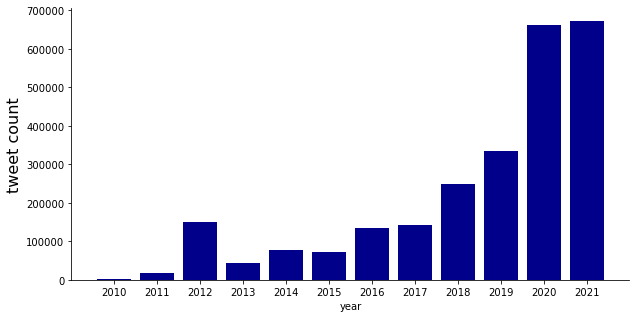

In [41]:
import matplotlib.pyplot as plt
import numpy as np
counts, years = np.histogram(timelines["year"], bins=range(2010, 2022))
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(timelines["year"].value_counts(ascending=True).index,
       timelines["year"].value_counts(ascending=True).values,
       color="DarkBlue")
ax.set_xticks(range(2010, 2022))
ax.set_ylabel("tweet count", fontsize=16)
ax.set_xlabel("year", fontsize=10)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig("../../plots/corpus_tweets_year_count.pdf")